In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import namedtuple
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# General utils

In [ ]:
def build_initial_graph(print_map, total_colors_num):
    nodes = []
    edges = []
    weights = []

    for m in range(len(print_map)): # for every line in df
        current_node = "L"+str(print_map.Layer[m])+"R"+str(print_map.Region[m])
        nodes.append(current_node)
        for c in range(total_colors_num): # for every possible color
            running_node = "L"+str(print_map.Layer[m]-1)+"R"+str(c) # consider just a layer below
            if(print_map["*R"+str(c)][m] != 0): # if there is any overlap with a region below -> add edge
                edges.append((str(current_node), str(running_node)))
                if(print_map.Region[m] == c): # weight for the same tool
                    weights.append(1)
                else:
                    weights.append(4)
        # check if this is a first layer of this color
        current_layer = print_map.Layer[m]
        current_region = print_map.Region[m]
        if(current_layer == print_map[print_map.Region == current_region][print_map.Exist == 1].Layer.min() and current_layer != 0):
            for c in range(total_colors_num): # for every possible color
                running_node = "L"+str(print_map.Layer[m])+"R"+str(c) # consider just a layer below
                if(current_region != c and list(print_map[print_map.Region == c][print_map.Layer == current_layer].Exist)[0] == 1):
                    edges.append((str(current_node), str(running_node)))
                    weights.append(4)


    Graph = namedtuple("Graph", ["nodes", "edges", "is_directed"])
    G = Graph(nodes, edges, is_directed=True)
    Gnx = nx.DiGraph(edges)

    # propagate weights
    i = 0
    for edge in Gnx.edges:
        Gnx.edges[edge[0],edge[1]]['weight'] = weights[i]
        i += 1

    print(str(len(Gnx.nodes))+" Nodes: ", list(Gnx.nodes))
    print(str(len(Gnx.edges))+" Edges: ", list(Gnx.edges))
    print("Edges with weights: ", list(Gnx.edges.data("weight")))
    #print(str(len(weights))+" Nodes: ", weights)
    return G, Gnx


# create a new graph according to the visited_nodes
def build_final_graph(visited_nodes_list):
    edges = []
    weights = []

    for n in range(len(visited_nodes_list)-1): # for every node
        current_node = visited_nodes_list[n]
        next_node = visited_nodes_list[n+1]
        edges.append((str(current_node), str(next_node)))

        #current_color = int(visited_nodes_list[n][3])
        #next_color = int(visited_nodes_list[n+1][3])
        current_color = int(current_node[current_node.index('R')+1:])
        next_color = int(next_node[next_node.index('R')+1:])
        if(current_color == next_color):
            weights.append(0)
        else:
            weights.append(1)

    Graph = namedtuple("Graph", ["nodes", "edges", "is_directed"])
    G = Graph(visited_nodes_list, edges, is_directed=True)
    Gnx = nx.DiGraph(edges)

    # propagate weights
    i = 0
    for edge in Gnx.edges:
        Gnx.edges[edge[0],edge[1]]['weight'] = weights[i]
        i += 1

    #print(str(len(Gnx.nodes))+" Nodes: ", list(Gnx.nodes))
    #print(str(len(Gnx.edges))+" Edges: ", list(Gnx.edges))
    #print("Edges with weights: ", list(Gnx.edges.data("weight")))
    #print(str(len(weights))+" Nodes: ", weights)
    #print(weights)
    return weights, G, Gnx


def plot_graph(Gnx):
    color_map = []
    pos = {}
    for node in Gnx:
        node_layer = int(node[1:node.index('R')])
        node_region = int(node[node.index('R')+1:])
        # assign position for each node according to the L and R location
        # pos = [region, layer]
        pos[str(node)] = [node_region, node_layer]

        # assign color for each node according to its tool (Region number)
        if(node_region == 0): # color 0
            color_map.append('silver')
        elif(node_region == 1): # color 1
            color_map.append('dodgerblue')
        elif(node_region == 2): # color 2
            color_map.append('tomato')
        elif(node_region == 3): # color 3
            color_map.append('gold')
        elif(node_region == 4): # color 4
            color_map.append('limegreen')
        else:
            color_map.append('red')

    plt.figure(figsize=(5,6))
    nx.draw(Gnx,pos,with_labels=True,node_color=color_map,alpha=0.9,node_size=500,
        edgecolors="k",edge_color='peru',font_size=8,font_weight='normal',font_color="k",width=1)
    nx.draw_networkx_edge_labels(Gnx,pos,edge_labels=nx.get_edge_attributes(Gnx,"weight"),font_size=10)
    plt.title('Fabrication map dependencies')
    plt.show()


def plot_initial_and_final_graphs(Gnx, Gnxf, no_of_TC):
    color_map_initial = []
    pos_initial = {}
    for node in Gnx:
        node_layer = int(node[1:node.index('R')])
        node_region = int(node[node.index('R')+1:])
        # assign position for each node according to the L and R location
        pos_initial[str(node)] = [node_region, node_layer]
        # assign color for each node according to its tool (Region number)
        if(node_region == 0): # color 0
            color_map_initial.append('silver')
        elif(node_region == 1): # color 1
            color_map_initial.append('dodgerblue')
        elif(node_region == 2): # color 2
            color_map_initial.append('tomato')
        elif(node_region == 3): # color 3
            color_map_initial.append('gold')
        elif(node_region == 4): # color 4
            color_map_initial.append('limegreen')
        else:
            color_map_initial.append('red')

    color_map_final = []
    pos_final = {}
    for node in Gnxf:
        node_layer = int(node[1:node.index('R')])
        node_region = int(node[node.index('R')+1:])
        # assign position for each node according to the L and R location
        pos_final[str(node)] = [node_region, node_layer]
        # assign color for each node according to its tool (Region number)
        if(node_region == 0): # color 0
            color_map_final.append('silver')
        elif(node_region == 1): # color 1
            color_map_final.append('dodgerblue')
        elif(node_region == 2): # color 2
            color_map_final.append('tomato')
        elif(node_region == 3): # color 3
            color_map_final.append('gold')
        elif(node_region == 4): # color 4
            color_map_final.append('limegreen')
        else:
            color_map_final.append('red')

    plt.figure(figsize=(14,10))
    plt.subplot(1,2,1)
    nx.draw(Gnx,pos_initial,with_labels=True,node_color=color_map_initial,alpha=0.9,node_size=500,
        edgecolors="k",edge_color='peru',font_size=8,font_weight='normal',font_color="k",width=1)
    #nx.draw_networkx_edge_labels(Gnx,pos_initial,edge_labels=nx.get_edge_attributes(Gnx,"weight"),font_size=8)
    plt.title('Initial graph')

    plt.subplot(1,2,2)
    nx.draw(Gnxf,pos_final,with_labels=True,node_color=color_map_final,alpha=0.9,node_size=400,
        edgecolors="k",edge_color='red',font_size=6,font_weight='normal',font_color="k",width=1)
    nx.draw_networkx_edge_labels(Gnxf,pos_final,edge_labels=nx.get_edge_attributes(Gnxf,"weight"),font_size=6)
    plt.title('Final graph (TC = ' + str(no_of_TC)+')')
    plt.show()


# adjacency list for directed graph
def adjacency_list_DG(graph):
    adj = {node: [] for node in graph.nodes}
    for edge in graph.edges:
        node1, node2 = edge[0], edge[1]
        adj[node1].append(node2)
        if not graph.is_directed:
            adj[node2].append(node1)
    return adj


# adjacency list for undirected graph
def adjacency_list_UG(graph):
    adj = {node: [] for node in graph.nodes}
    for edge in graph.edges:
        node1, node2 = edge[0], edge[1]
        adj[node1].append(node2)
        adj[node2].append(node1)
    return adj

# Traversal functions

In [ ]:
def generate_nodes_to_print_from_map(max_colors, print_map):
    nodes_to_print = {new_list: [] for new_list in range(max_colors)} # all initial nodes to print
    for m in range(len(print_map)): # for every line in df
        current_node = "L"+str(print_map.Layer[m])+"R"+str(print_map.Region[m])
        if(bool(print_map.Exist[m] == True)):
            nodes_to_print[print_map.Region[m]].append(str(current_node))
    #print('nodes_to_print: ', nodes_to_print)
    return nodes_to_print


def generate_color_bank(max_colors):
    # color_bank is for jumping between tools
    color_bank = []
    color_bank.extend(range(0, max_colors))
    #print('color_bank: ', color_bank)
    return color_bank


def check_if_next_node_is_printable(start_node, adj_list, trashbag):
    is_printable = []
    node_layer = int(start_node[1:start_node.index('R')])
    node_region = int(start_node[start_node.index('R')+1:])
    node_to_check = 'L'+str(node_layer+1)+'R'+str(node_region)
    for dependant in adj_list[node_to_check]:
        if dependant in trashbag:
            is_printable.append(True)
        else:
            is_printable.append(False)
    return all(is_printable)


def find_fabrication_path(adj_list, nodes_to_print, visited_nodes_list, trashbag, max_colors, max_layers, color_bank, start_node):
    for i in range(100):
      if start_node not in trashbag:
          current_layer = int(start_node[1:start_node.index('R')])
          current_region = int(start_node[start_node.index('R')+1:])
          # append visited node => we print this element
          visited_nodes_list.append(start_node)
          # remove from 'nodes_to_print' => this element is already printed
          nodes_to_print[current_region].remove(str(start_node))
          # trashbag is just for easy testing for now
          trashbag.add(start_node)

          if((current_layer < max_layers-1 and len(adj_list['L'+str(current_layer+1)+'R'+str(current_region)]) == 1)\
             or (current_layer < max_layers-1 and (len(adj_list['L'+str(current_layer+1)+'R'+str(current_region)]) > 1 and check_if_next_node_is_printable(start_node, adj_list, trashbag) == True))):
              start_node = 'L'+str(current_layer+1)+'R'+str(current_region)
          elif((current_layer < max_layers-1 and (len(adj_list['L'+str(current_layer+1)+'R'+str(current_region)]) > 1 and check_if_next_node_is_printable(start_node, adj_list, trashbag) == False))\
                or current_layer == max_layers-1\
                or (current_layer < max_layers-1 and len(adj_list['L'+str(current_layer+1)+'R'+str(current_region)]) == 0)):
              if(len(color_bank) > 1):
                  color_bank.remove(current_region)
                  color_to_jump = int(np.random.choice(color_bank))
                  # jump to 'color_to_jump' tool, first element which is left in the list
                  start_node = nodes_to_print[color_to_jump][0]
              else:
                  # refresh color_bank for a new batch
                  color_bank = generate_color_bank(max_colors)

                  # before making another jump, make sure that any nodes left for that color
                  for j in range(max_colors):
                      if(len(nodes_to_print[j]) == 0):
                          color_bank.remove(j)

                  # and make another random jump to node in nodes_to_print, but not in trashbag
                  if(len(color_bank) != 0):
                      color_to_jump = int(np.random.choice(color_bank))
                      start_node = nodes_to_print[color_to_jump][0]
                  else:
                      pass
                      #print('FINISHED')
      #print(visited_nodes_list)
    return visited_nodes_list

# Implementation

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/TSP_data/tsp_test_model2.csv'

print_map = pd.read_csv(filename)
print_map[:5]

,No.,Layer,Region,Exist,X,Y,Tool,*R0,*R1,*R2,*R3,*R4,*R5,*R6,*R7
0,0,0,0,1,0,0,k,0,0,0,0,0,0,0,0
1,1,0,1,1,5,0,c,0,0,0,0,0,0,0,0
2,2,0,2,1,5,5,m,0,0,0,0,0,0,0,0
3,3,0,3,1,15,0,y,0,0,0,0,0,0,0,0
4,4,0,4,0,0,0,g,0,0,0,0,0,0,0,0


<ipython-input-108-2e19c078edbd>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if(current_layer == print_map[print_map.Region == current_region][print_map.Exist == 1].Layer.min() and current_layer != 0):
<ipython-input-108-2e19c078edbd>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if(current_layer == print_map[print_map.Region == current_region][print_map.Exist == 1].Layer.min() and current_layer != 0):
<ipython-input-108-2e19c078edbd>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if(current_layer == print_map[print_map.Region == current_region][print_map.Exist == 1].Layer.min() and current_layer != 0):
<ipython-input-108-2e19c078edbd>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if(current_layer == print_map[print_map.Region == current_region][print_map.Exist == 1].Layer.min() and current_layer != 0):
<ipython-input-108-2e19c078edbd>:20: Use

38 Nodes:  ['L1R0', 'L0R0', 'L1R1', 'L0R1', 'L1R2', 'L0R2', 'L1R3', 'L0R3', 'L2R0', 'L2R1', 'L2R2', 'L2R3', 'L3R0', 'L3R1', 'L3R3', 'L4R0', 'L4R1', 'L4R3', 'L5R0', 'L5R2', 'L5R3', 'L5R4', 'L6R0', 'L6R1', 'L6R2', 'L6R3', 'L6R4', 'L7R0', 'L7R1', 'L7R3', 'L7R4', 'L8R0', 'L8R1', 'L8R4', 'L9R0', 'L9R4', 'L10R4', 'L11R4']
49 Edges:  [('L1R0', 'L0R0'), ('L1R1', 'L0R1'), ('L1R2', 'L0R2'), ('L1R3', 'L0R3'), ('L2R0', 'L1R0'), ('L2R1', 'L1R0'), ('L2R1', 'L1R1'), ('L2R1', 'L1R2'), ('L2R2', 'L1R0'), ('L2R2', 'L1R2'), ('L2R3', 'L1R3'), ('L3R0', 'L2R0'), ('L3R1', 'L2R1'), ('L3R1', 'L2R2'), ('L3R3', 'L2R3'), ('L4R0', 'L3R0'), ('L4R0', 'L3R1'), ('L4R1', 'L3R1'), ('L4R3', 'L3R3'), ('L5R0', 'L4R0'), ('L5R0', 'L4R1'), ('L5R2', 'L4R1'), ('L5R3', 'L4R3'), ('L5R4', 'L5R0'), ('L5R4', 'L5R2'), ('L5R4', 'L5R3'), ('L6R0', 'L5R0'), ('L6R1', 'L5R0'), ('L6R2', 'L5R2'), ('L6R3', 'L5R3'), ('L6R4', 'L5R4'), ('L7R0', 'L6R0'), ('L7R1', 'L6R1'), ('L7R3', 'L6R3'), ('L7R4', 'L6R2'), ('L7R4', 'L6R4'), ('L8R0', 'L7R0'), ('L8

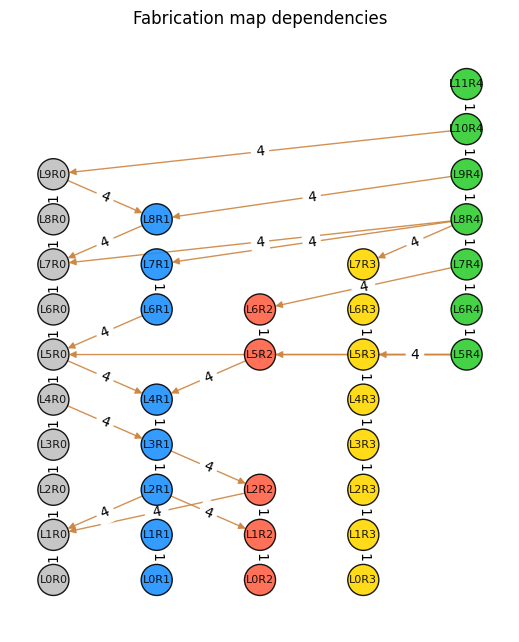

In [ ]:
max_colors = 5
G, Gnx = build_initial_graph(print_map, max_colors)

plot_graph(Gnx)

# Find a better path

In [ ]:
max_colors = 5
max_layers = 12
trashbag = set() # unordered elements
visited_nodes_list = []
adj_list = adjacency_list_DG(G)
start_node = 'L0R0'

nodes_to_print = generate_nodes_to_print_from_map(max_colors, print_map)
color_bank = generate_color_bank(max_colors)

path = find_fabrication_path(adj_list, nodes_to_print, visited_nodes_list, trashbag, max_colors, max_layers, color_bank, start_node)

weights_list, Gf, Gnxf = build_final_graph(path)
no_of_TC = sum(weights_list)
print('------------------')
print('nodes_to_print: ', nodes_to_print)
print('Number of TC = ', no_of_TC)
print('Path: ', path)

------------------
nodes_to_print:  {0: [], 1: [], 2: [], 3: [], 4: []}
Number of TC =  11
Path:  ['L0R0', 'L1R0', 'L2R0', 'L3R0', 'L0R3', 'L1R3', 'L2R3', 'L3R3', 'L4R3', 'L5R3', 'L6R3', 'L7R3', 'L5R4', 'L6R4', 'L0R2', 'L1R2', 'L2R2', 'L0R1', 'L1R1', 'L2R1', 'L3R1', 'L4R1', 'L7R4', 'L5R2', 'L6R2', 'L4R0', 'L5R0', 'L6R0', 'L7R0', 'L8R0', 'L6R1', 'L7R1', 'L8R1', 'L8R4', 'L9R4', 'L9R0', 'L10R4', 'L11R4']


In [ ]:
start_node = 'L0R1'
node_layer = int(start_node[1:start_node.index('R')])
node_region = int(start_node[start_node.index('R')+1:])
node_to_check = 'L'+str(node_layer+1)+'R'+str(node_region)
#adj_list[start_node]
node_to_check

'L1R1'

In [ ]:
adj_list

{'L0R0': [],
 'L0R1': [],
 'L0R2': [],
 'L0R3': [],
 'L0R4': [],
 'L1R0': ['L0R0'],
 'L1R1': ['L0R1'],
 'L1R2': ['L0R2'],
 'L1R3': ['L0R3'],
 'L1R4': [],
 'L2R0': ['L1R0'],
 'L2R1': ['L1R0', 'L1R1', 'L1R2'],
 'L2R2': ['L1R0', 'L1R2'],
 'L2R3': ['L1R3'],
 'L2R4': [],
 'L3R0': ['L2R0'],
 'L3R1': ['L2R1', 'L2R2'],
 'L3R2': [],
 'L3R3': ['L2R3'],
 'L3R4': [],
 'L4R0': ['L3R0', 'L3R1'],
 'L4R1': ['L3R1'],
 'L4R2': [],
 'L4R3': ['L3R3'],
 'L4R4': [],
 'L5R0': ['L4R0', 'L4R1'],
 'L5R1': [],
 'L5R2': ['L4R1'],
 'L5R3': ['L4R3'],
 'L5R4': ['L5R0', 'L5R2', 'L5R3'],
 'L6R0': ['L5R0'],
 'L6R1': ['L5R0'],
 'L6R2': ['L5R2'],
 'L6R3': ['L5R3'],
 'L6R4': ['L5R4'],
 'L7R0': ['L6R0'],
 'L7R1': ['L6R1'],
 'L7R2': [],
 'L7R3': ['L6R3'],
 'L7R4': ['L6R2', 'L6R4'],
 'L8R0': ['L7R0'],
 'L8R1': ['L7R0'],
 'L8R2': [],
 'L8R3': [],
 'L8R4': ['L7R0', 'L7R1', 'L7R3', 'L7R4'],
 'L9R0': ['L8R0', 'L8R1'],
 'L9R1': [],
 'L9R2': [],
 'L9R3': [],
 'L9R4': ['L8R1', 'L8R4'],
 'L10R0': [],
 'L10R1': [],
 'L10R2': [],
 'L1

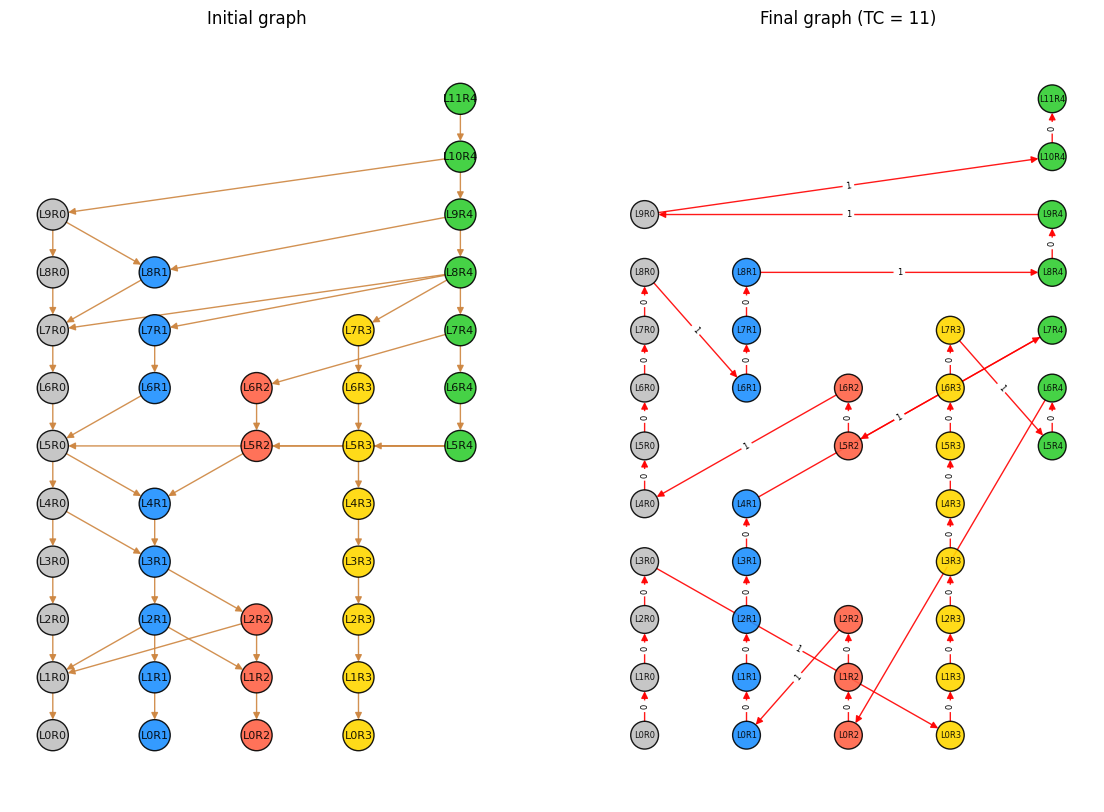

In [ ]:
plot_initial_and_final_graphs(Gnx, Gnxf, no_of_TC)

# Run optimization loop

In [ ]:
max_colors = 5
max_layers = 12
adj_list = adjacency_list_DG(G)
start_nodes = ['L0R0', 'L0R1', 'L0R2', 'L0R3']
list_of_TCs = []
best_path = None
worst_path = None
current_TC = 100
zero_TC = 0

for start_node in start_nodes:
    print('Start node: ', start_node)
    for i in tqdm(range(100)):
        #np.random.seed(10) # DEBUG
        trashbag = set() # unordered elements
        visited_nodes_list = []
        nodes_to_print = generate_nodes_to_print_from_map(max_colors, print_map)
        color_bank = generate_color_bank(max_colors)
        path = find_fabrication_path(adj_list, nodes_to_print, visited_nodes_list, trashbag, max_colors, max_layers, color_bank, start_node)
        weights_list, Gf, Gnxf = build_final_graph(path)
        no_of_TC = sum(weights_list)
        list_of_TCs.append(no_of_TC)
        if(no_of_TC < current_TC):
            best_path = path
            current_TC = no_of_TC
        if(no_of_TC > zero_TC):
            worst_path = path
            zero_TC = no_of_TC

Start node:  L0R0


100%|██████████| 100/100 [00:00<00:00, 260.20it/s]


Start node:  L0R1


100%|██████████| 100/100 [00:00<00:00, 162.14it/s]


Start node:  L0R2


100%|██████████| 100/100 [00:00<00:00, 259.25it/s]


Start node:  L0R3


100%|██████████| 100/100 [00:00<00:00, 275.72it/s]


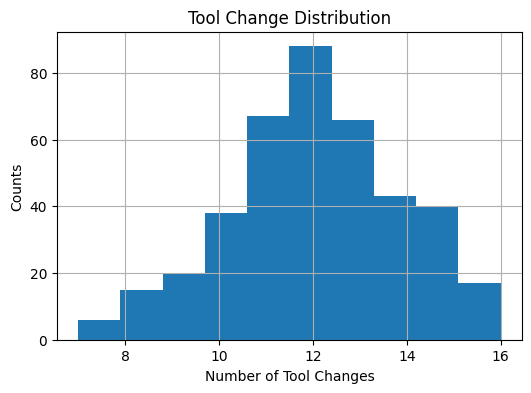

In [ ]:
plt.figure(figsize=(6,4))
#plt.hist(list_of_TCs, density=True, bins=10)  # density=False would make counts
plt.hist(list_of_TCs, density=False)
plt.ylabel('Counts')
plt.xlabel('Number of Tool Changes')
plt.grid()
plt.title('Tool Change Distribution')
plt.show()

# Best path

In [ ]:
weights_list, Gf, Gnxf = build_final_graph(best_path)
no_of_TC = sum(weights_list)
print('------------------')
print('nodes_to_print: ', nodes_to_print)
print('Number of TC = ', no_of_TC)
print('Path: ', best_path)

------------------
nodes_to_print:  {0: [], 1: [], 2: [], 3: [], 4: []}
Number of TC =  7
Path:  ['L0R0', 'L1R0', 'L2R0', 'L3R0', 'L0R3', 'L1R3', 'L2R3', 'L3R3', 'L4R3', 'L5R3', 'L6R3', 'L7R3', 'L5R4', 'L6R4', 'L0R2', 'L1R2', 'L2R2', 'L0R1', 'L1R1', 'L2R1', 'L3R1', 'L4R1', 'L6R1', 'L7R1', 'L8R1', 'L5R2', 'L6R2', 'L4R0', 'L5R0', 'L6R0', 'L7R0', 'L8R0', 'L9R0', 'L7R4', 'L8R4', 'L9R4', 'L10R4', 'L11R4']


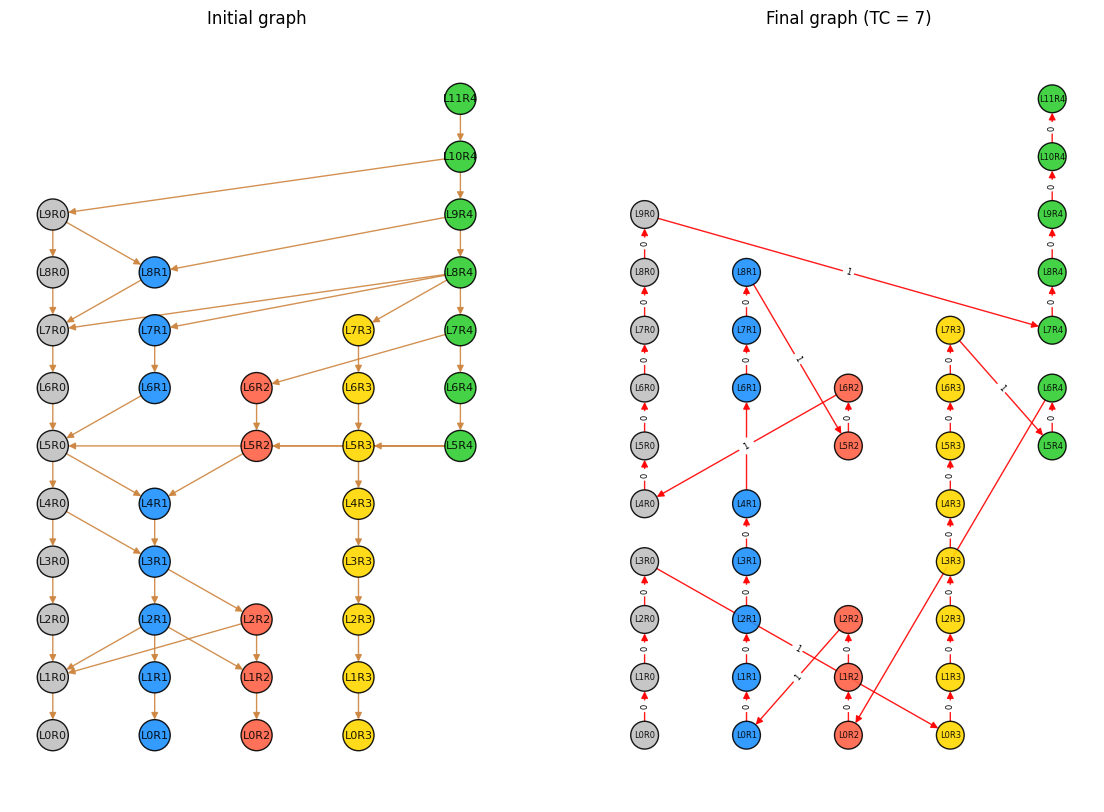

In [ ]:
plot_initial_and_final_graphs(Gnx, Gnxf, no_of_TC)

# Worst path

In [ ]:
weights_list, Gf, Gnxf = build_final_graph(worst_path)
no_of_TC = sum(weights_list)
print('------------------')
print('nodes_to_print: ', nodes_to_print)
print('Number of TC = ', no_of_TC)
print('Path: ', worst_path)

------------------
nodes_to_print:  {0: [], 1: [], 2: [], 3: [], 4: []}
Number of TC =  16
Path:  ['L0R1', 'L1R1', 'L5R4', 'L6R4', 'L0R2', 'L1R2', 'L0R3', 'L1R3', 'L2R3', 'L3R3', 'L4R3', 'L5R3', 'L6R3', 'L7R3', 'L0R0', 'L1R0', 'L2R0', 'L3R0', 'L7R4', 'L2R1', 'L4R0', 'L2R2', 'L3R1', 'L4R1', 'L8R4', 'L5R0', 'L6R0', 'L7R0', 'L8R0', 'L5R2', 'L6R2', 'L9R4', 'L9R0', 'L6R1', 'L7R1', 'L8R1', 'L10R4', 'L11R4']


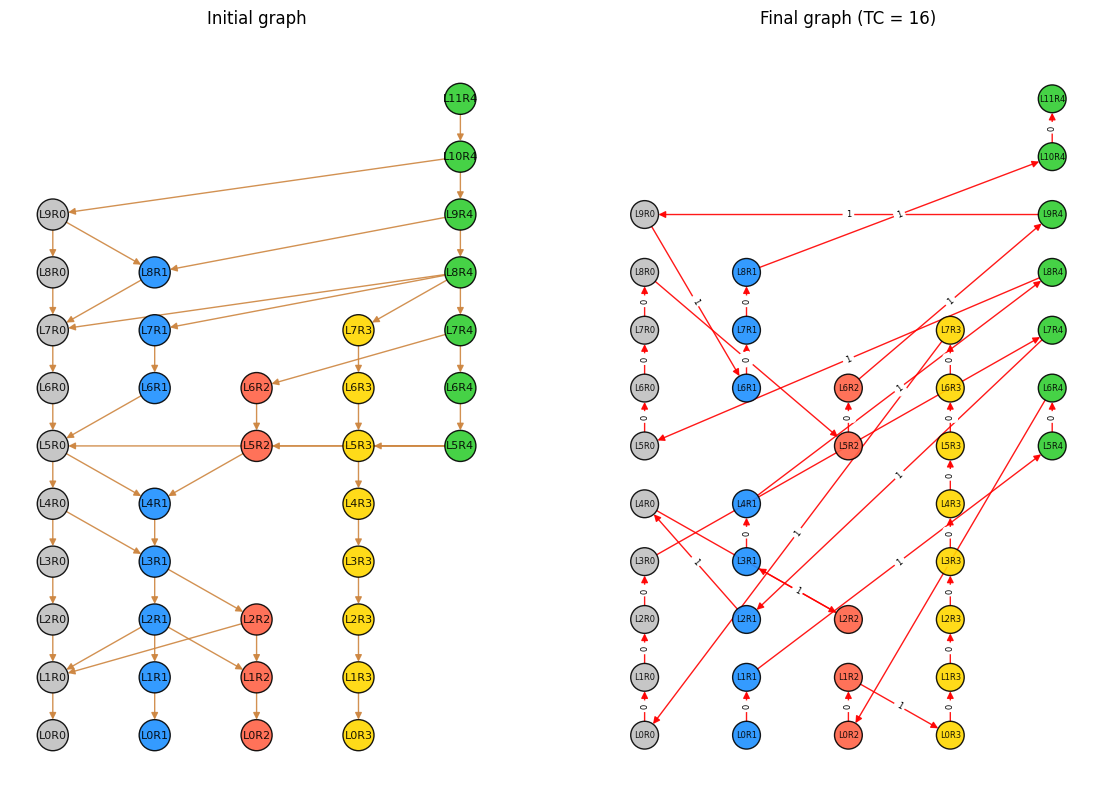

In [ ]:
plot_initial_and_final_graphs(Gnx, Gnxf, no_of_TC)

# Debug

In [ ]:
for i in range(55):
    if start_node not in trashbag:
        #print(start_node)
        #current_layer = int(start_node[1])
        #current_region = int(start_node[3])
        current_layer = int(start_node[1:start_node.index('R')])
        current_region = int(start_node[start_node.index('R')+1:])
        # append visited node => we print this element
        visited_nodes_list.append(start_node)
        # remove from 'nodes_to_print' => this element is already printed
        nodes_to_print[current_region].remove(str(start_node))

        # trashbag is just for easy testing for now
        trashbag.add(start_node)

        if((current_layer < max_layers-1 and len(adj_list['L'+str(current_layer+1)+'R'+str(current_region)]) == 1)\
           or (current_layer < max_layers-1 and (len(adj_list['L'+str(current_layer+1)+'R'+str(current_region)]) > 1 and check_if_next_node_is_printable(start_node, adj_list, trashbag) == True))):
            start_node = 'L'+str(current_layer+1)+'R'+str(current_region)
        elif((current_layer < max_layers-1 and (len(adj_list['L'+str(current_layer+1)+'R'+str(current_region)]) > 1 and check_if_next_node_is_printable(start_node, adj_list, trashbag) == False))\
              or current_layer == max_layers-1\
              or (current_layer < max_layers-1 and len(adj_list['L'+str(current_layer+1)+'R'+str(current_region)]) == 0)):
            if(len(color_bank) > 1):
                color_bank.remove(current_region)
                color_to_jump = int(random.choice(color_bank))
                #color_bank.remove(color_to_jump)
                #start_node = 'L0R'+str(color_to_jump) # jump straight to L0
                # jump to 'color_to_jump' tool, first element which is left in the list
                start_node = nodes_to_print[color_to_jump][0]
                # we appending color_to_jump after removing because it will become current_region during next loop
                #color_bank.append(color_to_jump)
            else:
                # refresh color_bank for a new batch
                color_bank = generate_color_bank(max_colors)

                # before making another jump, make sure that any nodes left for that color
                for j in range(max_colors):
                    if(len(nodes_to_print[j]) == 0):
                        color_bank.remove(j)

                # and make another random jump to node in nodes_to_print, but not in trashbag
                if(len(color_bank) != 0):
                    color_to_jump = int(random.choice(color_bank))
                    start_node = nodes_to_print[color_to_jump][0]
                else:
                    print('FINISHED')
            #print('here')
    #print(visited_nodes_list)

print('--------')
print('list:', visited_nodes_list)
print('--------')
print('bag:', trashbag)